In [1]:
import math

from typing import Optional, List

import torch
from torch import nn
from labml import tracker


In [2]:
class PrepareForMultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, heads: int, d_k: int, bias: bool):
        super().__init__()
        # Linear layer for linear transform
        self.linear = nn.Linear(d_model, heads * d_k, bias=bias)
        self.heads = heads
        self.d_k = d_k # Number of dimensions in vectors in each head

    def forward(self, x: torch.Tensor):
        head_shape = x.shape[:-1] # We apply the linear transformation to the last dimension and split that into the heads.
        x = self.linear(x)
        x = x.view(*head_shape, self.heads, self.d_k)
        # Output has shape [seq_len, batch_size, heads, d_k] or [batch_size, heads, d_model]
        return x





![CleanShot 2025-02-28 at 17.12.30@2x.png](<attachment:CleanShot 2025-02-28 at 17.12.30@2x.png>)
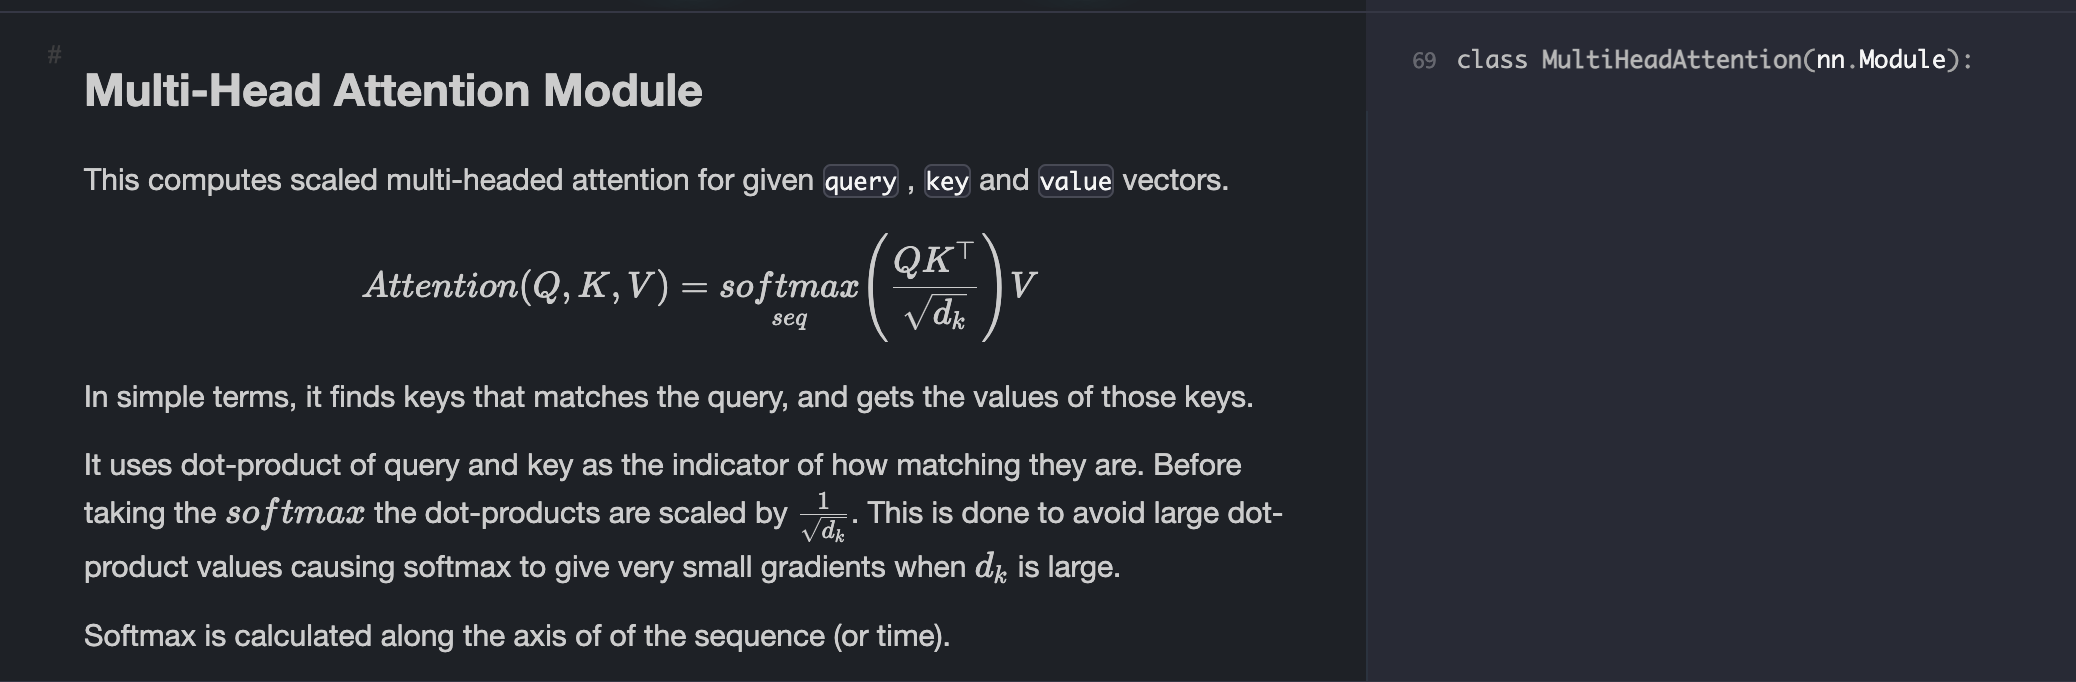

![CleanShot 2025-02-28 at 17.18.38@2x.png](<attachment:CleanShot 2025-02-28 at 17.18.38@2x.png>)
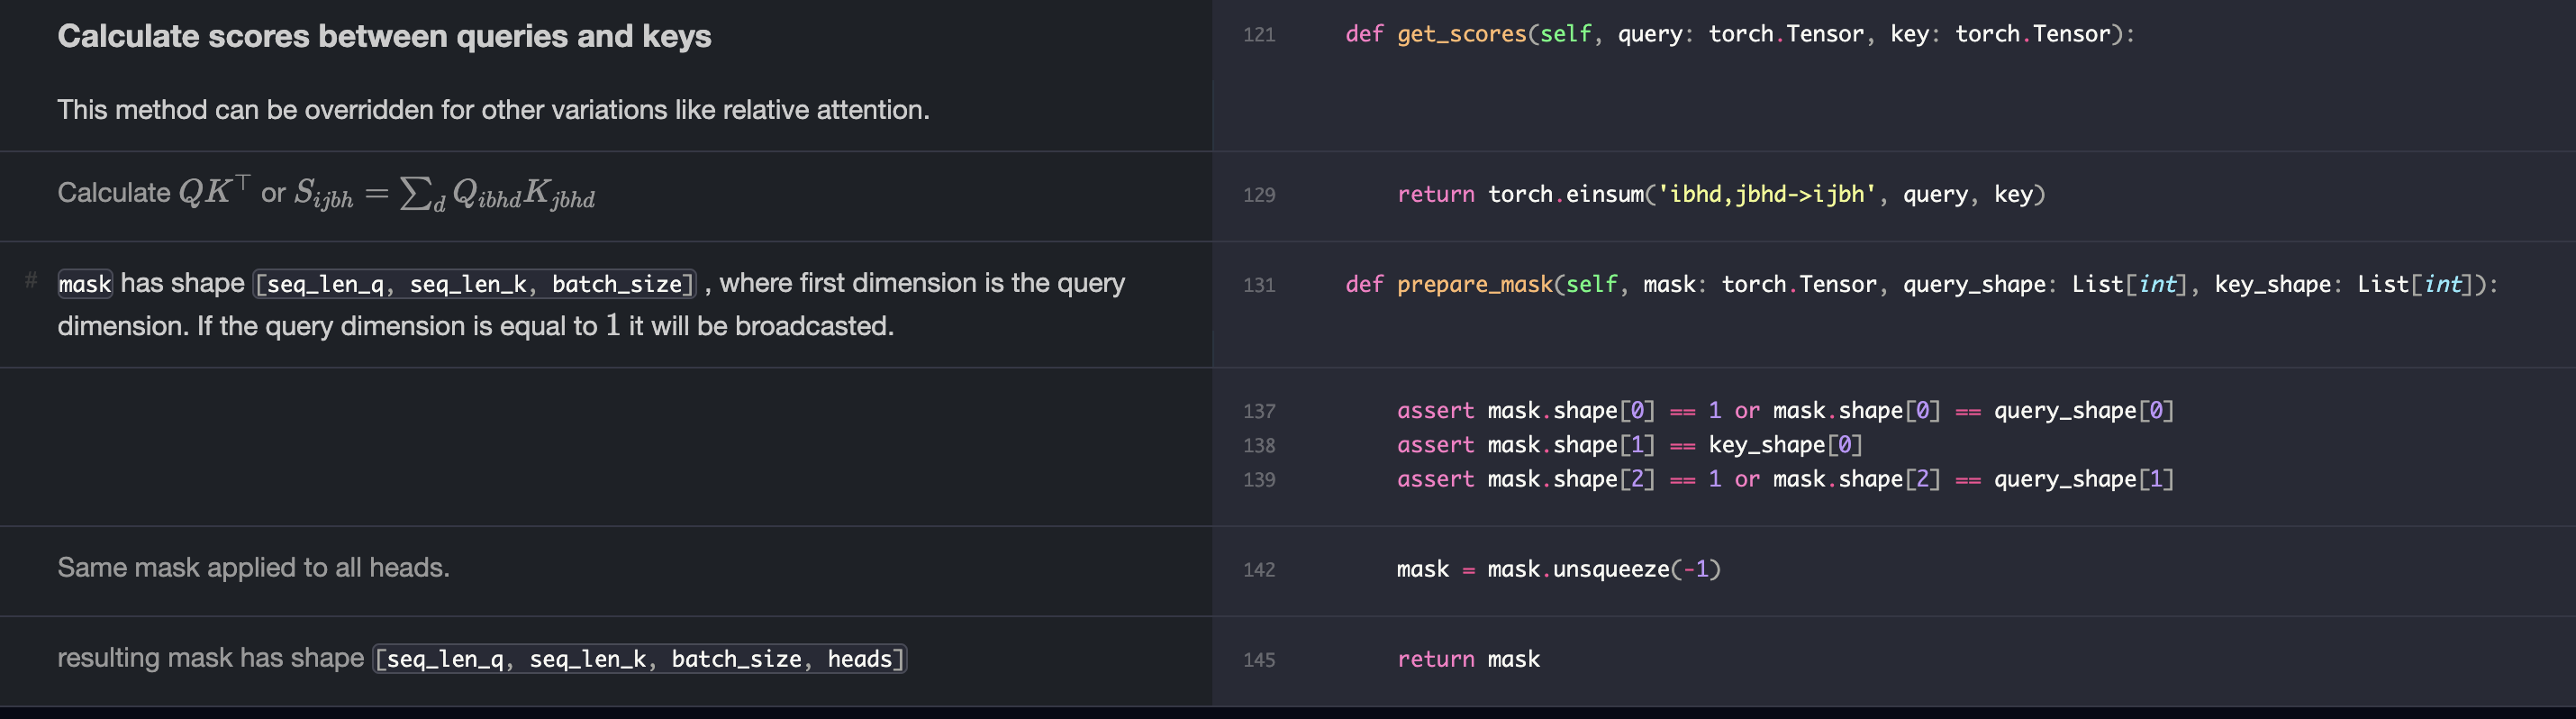

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads: int, d_model: int, dropout_prob: float = 0.1, bias: bool = True):
        super().__init__()
        self.d_k = d_model // heads # Number of features per head
        self.heads = heads # Number of heads
        self.query = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=bias)
        self.key = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=bias)
        self.value = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=True)
        self.softmax = nn.Softmax(dim=1) # Softmax for attention along the time dimension of key
        self.output = nn.Linear(d_model, d_model) # Output layer
        self.dropout = nn.Dropout(dropout_prob) # Dropout
        self.scale = 1 / math.sqrt(self.d_k) # Scaling factor before the softmax
        self.attn = None # We store attentions so that it can be used for logging, or other computations if needed

    def get_scores(self, query: torch.Tensor, key: torch.Tensor):
        return torch.einsum('ibhd,jbhd->ijbh', query, key)
    
    # mask has shape [seq_len_q, seq_len_k, batch_size] , where first dimension is the query dimension. If the query dimension is equal to 1 it will be broadcasted.

    def prepare_mask(self, mask: torch.Tensor, query_shape: List[int], key_shape: List[int]):
        assert mask.shape[0] == 1 or mask.shape[0] == query_shape[0]
        assert mask.shape[1] == key_shape[0]
        assert mask.shape[2] == 1 or mask.shape[2] == query_shape[1]
        # Same mask applied to all heads.
        mask = mask.unsqueeze(-1)
        return mask
    
    def forward(self, *,
                query: torch.Tensor,
                key: torch.Tensor,
                value: torch.Tensor,
                mask: Optional[torch.Tensor] = None):
        seq_len, batch_size, _ = query.shape
        if mask is not None:
            mask = self.prepare_mask(mask, query.shape, key.shape)
        
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)
        scores = self.get_scores(query, key)
        scores *= self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
            
        attn = self.softmax(scores)
        tracker.debug('attn', attn)
        attn = self.dropout(attn)
        x = torch.einsum("ijbh,jbhd->ibhd", attn, value)
        self.attn = attn.detach()
        x = torch.einsum("ijbh,jbhd->ibhd", attn, value)
        self.attn = attn.detach()
        x = x.reshape(seq_len, batch_size, -1)
        
        return self.output(x)

Prepare query , key and value for attention computation. These will then have shape [seq_len, batch_size, heads, d_k] .